# RFECV multi-class prediction

In [1]:
import pathlib

import anndata
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix,
                             fbeta_score, make_scorer)
from sklearn.model_selection import StratifiedKFold

## Parameters

In [2]:
cluster_col = 'SubType'
test_portion = 0.1
random_seed = 0
n_estimators = 1000
n_estimators_final = 5000
n_jobs = 40
n_splits = 5
cluster_order_path = None

In [3]:
output_dir = 'Model'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Marker Adata

In [4]:
adata = anndata.read_h5ad('Adata/train.h5ad')

In [5]:
test_adata = anndata.read_h5ad('Adata/test.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 56667 × 3364 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor', 'Replicate'
    var: 'chrom', 'start', 'end'

## Cluster Order

In [7]:
if cluster_order_path is not None:
    cluster_order = pd.read_csv(cluster_order_path, header=None, index_col=0).index
else:
    cluster_order = sorted(adata.obs[cluster_col].unique())

## Supervise training

In [8]:
n_cell = adata.shape[0]
n_test = test_adata.shape[0]

In [9]:
train_df = pd.DataFrame(adata.X,
                        index=adata.obs_names,
                        columns=adata.var_names)
train_label = adata.obs[cluster_col]

test_df = pd.DataFrame(test_adata.X,
                       index=test_adata.obs_names,
                       columns=test_adata.var_names)
test_label = test_adata.obs[cluster_col]

## Training

In [10]:
estimator = BalancedRandomForestClassifier(n_estimators=n_estimators,
                                           criterion='gini',
                                           max_depth=None,
                                           min_samples_split=2,
                                           min_samples_leaf=2,
                                           min_weight_fraction_leaf=0.0,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           oob_score=False,
                                           sampling_strategy='auto',
                                           replacement=False,
                                           n_jobs=10,
                                           random_state=random_seed,
                                           verbose=3,
                                           warm_start=False,
                                           class_weight=None)

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

# TODO change to balanced accuracy score
scoring = make_scorer(balanced_accuracy_score)

clf = RFECV(estimator,
            step=3,
            min_features_to_select=1,
            cv=cv,
            scoring=scoring,
            verbose=3,
            n_jobs=10)

In [11]:
train_df.shape, train_label.size

((56667, 3364), 56667)

In [ ]:
clf.fit(train_df, train_label)
joblib.dump(clf, 'Model/RFECV.lib')

In [10]:
clf = joblib.load('Model/RFECV.lib')

## Featurs

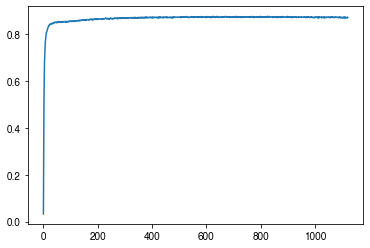

In [11]:
plt.plot(clf.grid_scores_)

In [12]:
feature_to_use = train_df.columns[clf.support_]
print(feature_to_use.size, 'features selected by RFECV')

1873 features selected by RFECV


In [33]:
adata.var.loc[feature_to_use].to_csv('Model/ModelFeature.csv')

## Testing

In [14]:
# final pred
pred_label = clf.predict(test_df)

# final pred proba
pred_proba = clf.predict_proba(test_df)
pred_proba = pd.DataFrame(pred_proba, index=test_df.index, columns=clf.classes_)
pred_proba = pred_proba[cluster_order].copy()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.2s finished


In [15]:
balanced_accuracy_score(test_label, pred_label)

0.8897988820544419

## Confusion matrix

In [16]:
cfm = confusion_matrix(test_label, pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 161)]

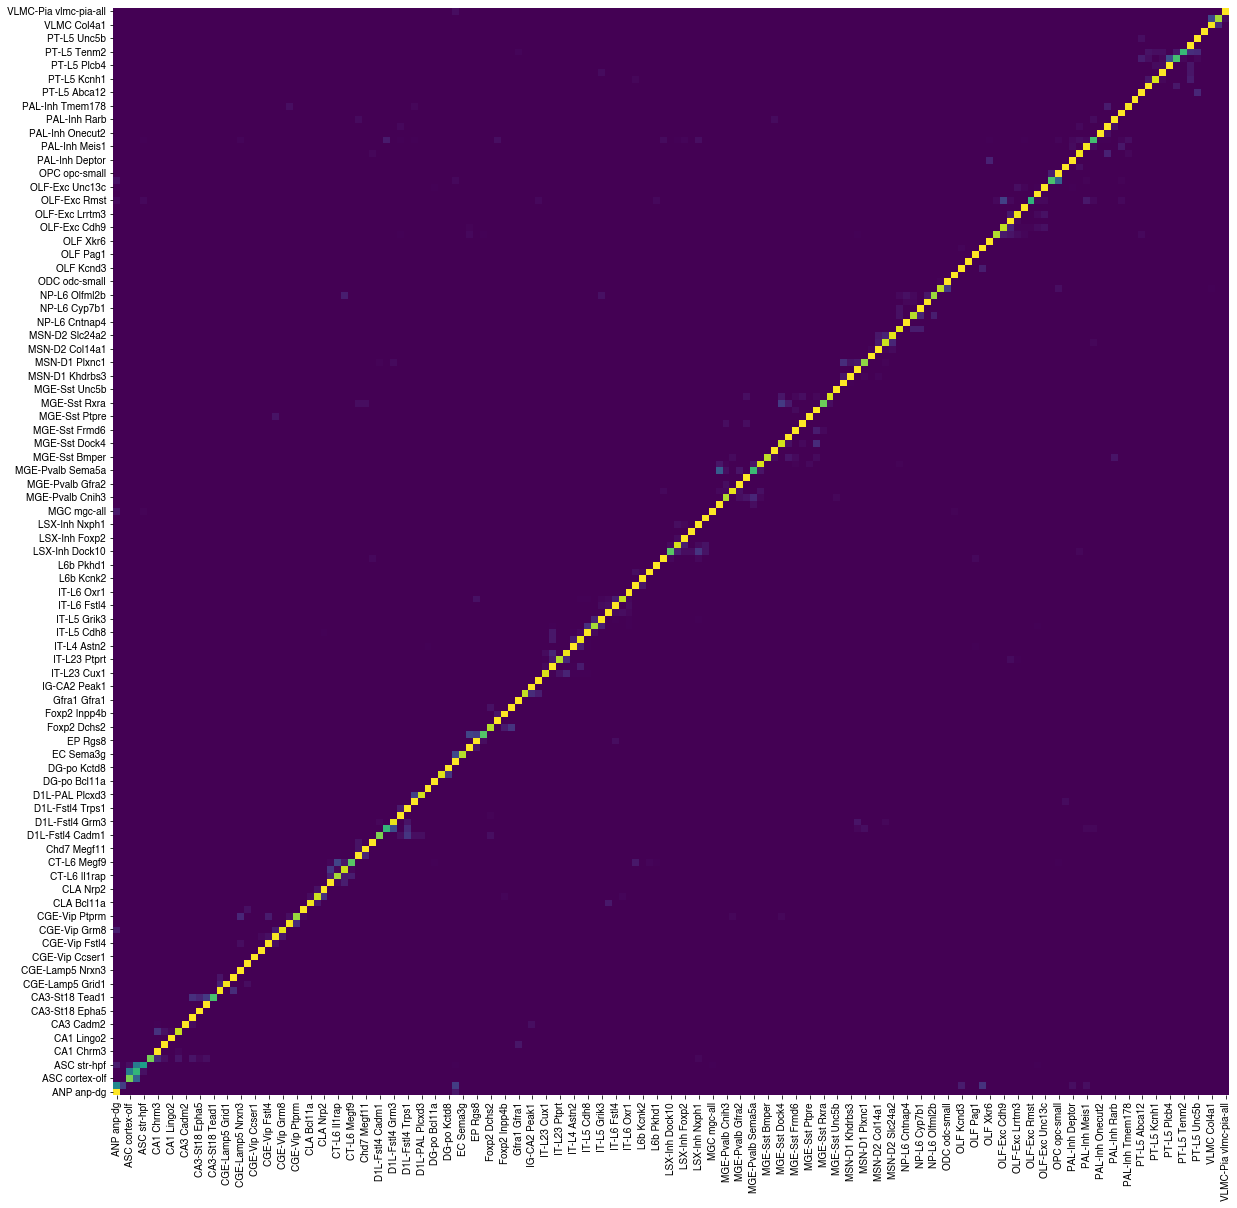

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=0.9, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [18]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = pred_proba.iloc[test_orders.argsort(), :]

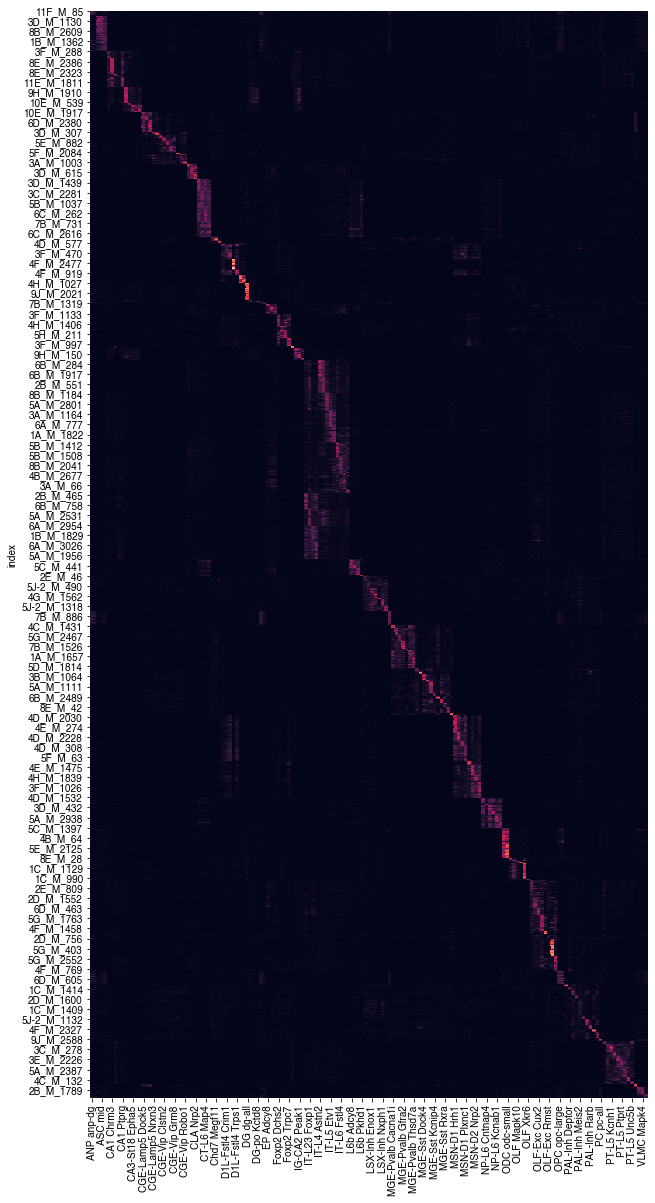

In [19]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

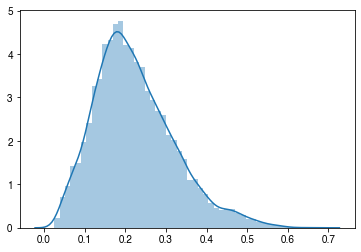

In [20]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

## Train final model with RFECV selected feature

In [21]:
selected_train_df = train_df.loc[:, feature_to_use]
selected_test_df = test_df.loc[:, feature_to_use]

In [22]:
# final estimator with larger trees
final_estimator = BalancedRandomForestClassifier(n_estimators=n_estimators_final,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 min_samples_split=2,
                                                 min_samples_leaf=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 bootstrap=True,
                                                 oob_score=False,
                                                 sampling_strategy='auto',
                                                 replacement=False,
                                                 n_jobs=40,
                                                 random_state=random_seed,
                                                 verbose=3,
                                                 warm_start=False,
                                                 class_weight=None)

In [23]:
final_estimator.fit(selected_train_df, train_label)
joblib.dump(final_estimator, 'Model/FinalClassifier.lib')

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.


building tree 3 of 5000
building tree 4 of 5000
building tree 18 of 5000
building tree 1 of 5000
building tree 26 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 31 of 5000
building tree 21 of 5000
building tree 35 of 5000building tree 27 of 5000

building tree 28 of 5000
building tree 13 of 5000
building tree 2 of 5000
building tree 16 of 5000
building tree 29 of 5000
building tree 23 of 5000
building tree 5 of 5000building tree 12 of 5000

building tree 30 of 5000
building tree 34 of 5000
building tree 25 of 5000
building tree 32 of 5000
building tree 7 of 5000
building tree 20 of 5000
building tree 40 of 5000
building tree 6 of 5000
building tree 39 of 5000
building tree 36 of 5000
building tree 11 of 5000
building tree 37 of 5000
building tree 19 of 5000
building tree 38 of 5000
building tree 24 of 5000
building tree 22 of 5000
building tree 10 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 17 of 5000
building tree 33 of 5000
building 

[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    4.9s


building tree 87 of 5000
building tree 91 of 5000
building tree 88 of 5000
building tree 86 of 5000
building tree 94 of 5000
building tree 93 of 5000building tree 97 of 5000

building tree 85 of 5000
building tree 101 of 5000
building tree 90 of 5000
building tree 102 of 5000
building tree 100 of 5000
building tree 104 of 5000
building tree 113 of 5000
building tree 98 of 5000
building tree 105 of 5000
building tree 108 of 5000
building tree 92 of 5000
building tree 99 of 5000building tree 96 of 5000
building tree 106 of 5000
building tree 95 of 5000

building tree 89 of 5000
building tree 109 of 5000
building tree 103 of 5000
building tree 111 of 5000
building tree 121 of 5000
building tree 117 of 5000
building tree 112 of 5000building tree 116 of 5000

building tree 107 of 5000
building tree 110 of 5000
building tree 118 of 5000
building tree 115 of 5000
building tree 114 of 5000
building tree 123 of 5000
building tree 119 of 5000
building tree 122 of 5000
building tree 120 of 5000
b

[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   13.1s


building tree 213 of 5000
building tree 214 of 5000
building tree 215 of 5000
building tree 216 of 5000
building tree 220 of 5000
building tree 217 of 5000
building tree 218 of 5000
building tree 219 of 5000
building tree 221 of 5000
building tree 224 of 5000
building tree 223 of 5000
building tree 228 of 5000
building tree 222 of 5000
building tree 230 of 5000building tree 236 of 5000

building tree 229 of 5000
building tree 234 of 5000
building tree 238 of 5000
building tree 226 of 5000
building tree 227 of 5000
building tree 225 of 5000
building tree 231 of 5000
building tree 239 of 5000
building tree 237 of 5000
building tree 245 of 5000
building tree 232 of 5000
building tree 240 of 5000
building tree 233 of 5000
building tree 242 of 5000
building tree 243 of 5000
building tree 246 of 5000
building tree 235 of 5000
building tree 247 of 5000
building tree 241 of 5000
building tree 244 of 5000
building tree 248 of 5000
building tree 250 of 5000
building tree 249 of 5000
building tre

[Parallel(n_jobs=40)]: Done 432 tasks      | elapsed:   25.6s


building tree 448 of 5000
building tree 452 of 5000
building tree 461 of 5000
building tree 457 of 5000
building tree 451 of 5000
building tree 458 of 5000
building tree 453 of 5000
building tree 455 of 5000
building tree 454 of 5000
building tree 459 of 5000
building tree 456 of 5000
building tree 460 of 5000
building tree 462 of 5000
building tree 464 of 5000
building tree 463 of 5000
building tree 468 of 5000
building tree 466 of 5000
building tree 465 of 5000
building tree 467 of 5000
building tree 469 of 5000
building tree 470 of 5000
building tree 471 of 5000
building tree 472 of 5000
building tree 473 of 5000
building tree 475 of 5000
building tree 474 of 5000
building tree 476 of 5000
building tree 477 of 5000
building tree 483 of 5000
building tree 486 of 5000
building tree 479 of 5000
building tree 478 of 5000
building tree 481 of 5000
building tree 480 of 5000
building tree 487 of 5000
building tree 488 of 5000
building tree 485 of 5000
building tree 484 of 5000
building tre

[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   40.3s


building tree 729 of 5000
building tree 733 of 5000
building tree 732 of 5000
building tree 735 of 5000
building tree 734 of 5000
building tree 736 of 5000
building tree 743 of 5000
building tree 744 of 5000
building tree 745 of 5000
building tree 737 of 5000
building tree 742 of 5000
building tree 740 of 5000
building tree 754 of 5000
building tree 746 of 5000
building tree 741 of 5000
building tree 739 of 5000
building tree 748 of 5000
building tree 738 of 5000building tree 749 of 5000

building tree 747 of 5000
building tree 751 of 5000
building tree 753 of 5000
building tree 750 of 5000
building tree 752 of 5000
building tree 755 of 5000
building tree 756 of 5000
building tree 757 of 5000
building tree 759 of 5000
building tree 758 of 5000
building tree 760 of 5000
building tree 766 of 5000building tree 764 of 5000

building tree 767 of 5000
building tree 761 of 5000
building tree 762 of 5000
building tree 763 of 5000
building tree 765 of 5000
building tree 770 of 5000
building tre

building tree 1046 of 5000
building tree 1044 of 5000
building tree 1052 of 5000
building tree 1053 of 5000
building tree 1055 of 5000
building tree 1056 of 5000
building tree 1057 of 5000
building tree 1051 of 5000
building tree 1054 of 5000
building tree 1059 of 5000
building tree 1062 of 5000
building tree 1061 of 5000
building tree 1058 of 5000
building tree 1060 of 5000
building tree 1065 of 5000
building tree 1066 of 5000
building tree 1064 of 5000
building tree 1063 of 5000
building tree 1067 of 5000
building tree 1071 of 5000
building tree 1069 of 5000
building tree 1068 of 5000
building tree 1073 of 5000
building tree 1070 of 5000
building tree 1074 of 5000
building tree 1072 of 5000
building tree 1075 of 5000


[Parallel(n_jobs=40)]: Done 1072 tasks      | elapsed:   58.1s


building tree 1076 of 5000
building tree 1078 of 5000
building tree 1080 of 5000
building tree 1081 of 5000
building tree 1079 of 5000
building tree 1077 of 5000
building tree 1083 of 5000
building tree 1085 of 5000
building tree 1089 of 5000
building tree 1086 of 5000
building tree 1082 of 5000
building tree 1084 of 5000
building tree 1088 of 5000
building tree 1094 of 5000
building tree 1097 of 5000
building tree 1087 of 5000
building tree 1092 of 5000
building tree 1090 of 5000
building tree 1093 of 5000
building tree 1091 of 5000
building tree 1096 of 5000
building tree 1099 of 5000
building tree 1095 of 5000
building tree 1098 of 5000
building tree 1101 of 5000
building tree 1102 of 5000
building tree 1100 of 5000
building tree 1105 of 5000
building tree 1103 of 5000
building tree 1106 of 5000
building tree 1104 of 5000
building tree 1107 of 5000
building tree 1108 of 5000
building tree 1109 of 5000
building tree 1111 of 5000
building tree 1112 of 5000
building tree 1110 of 5000
b

building tree 1386 of 5000building tree 1383 of 5000
building tree 1377 of 5000

building tree 1385 of 5000
building tree 1389 of 5000building tree 1381 of 5000

building tree 1390 of 5000
building tree 1388 of 5000
building tree 1395 of 5000
building tree 1387 of 5000
building tree 1391 of 5000
building tree 1394 of 5000
building tree 1393 of 5000
building tree 1396 of 5000
building tree 1392 of 5000
building tree 1397 of 5000
building tree 1399 of 5000
building tree 1398 of 5000
building tree 1402 of 5000
building tree 1400 of 5000
building tree 1401 of 5000
building tree 1405 of 5000building tree 1403 of 5000

building tree 1407 of 5000
building tree 1406 of 5000
building tree 1411 of 5000
building tree 1404 of 5000
building tree 1408 of 5000
building tree 1409 of 5000
building tree 1410 of 5000
building tree 1412 of 5000
building tree 1414 of 5000
building tree 1413 of 5000
building tree 1415 of 5000
building tree 1416 of 5000
building tree 1418 of 5000
building tree 1417 of 5000
b

[Parallel(n_jobs=40)]: Done 1488 tasks      | elapsed:  1.3min


building tree 1494 of 5000
building tree 1497 of 5000
building tree 1495 of 5000
building tree 1498 of 5000
building tree 1501 of 5000building tree 1500 of 5000

building tree 1499 of 5000
building tree 1502 of 5000
building tree 1503 of 5000
building tree 1504 of 5000
building tree 1505 of 5000
building tree 1507 of 5000
building tree 1509 of 5000
building tree 1508 of 5000
building tree 1506 of 5000
building tree 1514 of 5000
building tree 1510 of 5000
building tree 1512 of 5000
building tree 1513 of 5000
building tree 1516 of 5000building tree 1518 of 5000

building tree 1517 of 5000
building tree 1511 of 5000
building tree 1515 of 5000
building tree 1520 of 5000
building tree 1521 of 5000building tree 1519 of 5000

building tree 1523 of 5000
building tree 1524 of 5000
building tree 1525 of 5000
building tree 1526 of 5000
building tree 1527 of 5000
building tree 1528 of 5000
building tree 1522 of 5000
building tree 1530 of 5000
building tree 1529 of 5000
building tree 1531 of 5000
b

building tree 1802 of 5000
building tree 1803 of 5000
building tree 1800 of 5000
building tree 1801 of 5000
building tree 1805 of 5000
building tree 1808 of 5000
building tree 1804 of 5000
building tree 1806 of 5000
building tree 1807 of 5000
building tree 1809 of 5000
building tree 1811 of 5000
building tree 1812 of 5000
building tree 1810 of 5000
building tree 1814 of 5000
building tree 1815 of 5000
building tree 1816 of 5000
building tree 1813 of 5000
building tree 1817 of 5000
building tree 1818 of 5000
building tree 1820 of 5000
building tree 1821 of 5000
building tree 1822 of 5000
building tree 1819 of 5000
building tree 1823 of 5000
building tree 1825 of 5000
building tree 1827 of 5000
building tree 1824 of 5000
building tree 1826 of 5000
building tree 1828 of 5000
building tree 1829 of 5000
building tree 1830 of 5000
building tree 1835 of 5000
building tree 1833 of 5000
building tree 1832 of 5000
building tree 1836 of 5000
building tree 1839 of 5000
building tree 1834 of 5000
b

[Parallel(n_jobs=40)]: Done 1968 tasks      | elapsed:  1.9min


building tree 1980 of 5000
building tree 1976 of 5000
building tree 1984 of 5000
building tree 1981 of 5000
building tree 1983 of 5000building tree 1982 of 5000

building tree 1985 of 5000
building tree 1986 of 5000
building tree 1987 of 5000
building tree 1988 of 5000
building tree 1993 of 5000
building tree 1992 of 5000
building tree 1989 of 5000
building tree 1990 of 5000
building tree 1991 of 5000
building tree 1994 of 5000
building tree 1995 of 5000
building tree 1996 of 5000
building tree 1998 of 5000
building tree 1997 of 5000
building tree 1999 of 5000
building tree 2003 of 5000
building tree 2001 of 5000
building tree 2000 of 5000
building tree 2002 of 5000
building tree 2004 of 5000
building tree 2008 of 5000
building tree 2007 of 5000
building tree 2005 of 5000building tree 2009 of 5000

building tree 2011 of 5000
building tree 2006 of 5000
building tree 2013 of 5000
building tree 2014 of 5000
building tree 2010 of 5000
building tree 2016 of 5000
building tree 2015 of 5000
b

building tree 2290 of 5000
building tree 2289 of 5000
building tree 2291 of 5000
building tree 2292 of 5000building tree 2293 of 5000

building tree 2294 of 5000
building tree 2296 of 5000
building tree 2297 of 5000
building tree 2295 of 5000
building tree 2298 of 5000
building tree 2300 of 5000
building tree 2302 of 5000
building tree 2303 of 5000
building tree 2299 of 5000
building tree 2306 of 5000
building tree 2304 of 5000
building tree 2305 of 5000
building tree 2301 of 5000
building tree 2307 of 5000
building tree 2309 of 5000
building tree 2310 of 5000
building tree 2308 of 5000
building tree 2312 of 5000
building tree 2314 of 5000
building tree 2319 of 5000
building tree 2315 of 5000
building tree 2316 of 5000
building tree 2313 of 5000
building tree 2311 of 5000
building tree 2321 of 5000building tree 2318 of 5000

building tree 2320 of 5000building tree 2317 of 5000

building tree 2322 of 5000
building tree 2324 of 5000
building tree 2328 of 5000building tree 2323 of 5000

b

[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  2.3min


building tree 2524 of 5000
building tree 2522 of 5000
building tree 2525 of 5000building tree 2523 of 5000

building tree 2530 of 5000
building tree 2527 of 5000
building tree 2528 of 5000
building tree 2529 of 5000
building tree 2526 of 5000
building tree 2531 of 5000
building tree 2533 of 5000
building tree 2532 of 5000
building tree 2534 of 5000
building tree 2539 of 5000
building tree 2538 of 5000
building tree 2535 of 5000
building tree 2536 of 5000
building tree 2537 of 5000
building tree 2540 of 5000
building tree 2542 of 5000
building tree 2541 of 5000
building tree 2543 of 5000
building tree 2548 of 5000
building tree 2544 of 5000
building tree 2549 of 5000
building tree 2545 of 5000
building tree 2547 of 5000
building tree 2546 of 5000
building tree 2554 of 5000
building tree 2551 of 5000
building tree 2550 of 5000
building tree 2555 of 5000
building tree 2552 of 5000
building tree 2553 of 5000
building tree 2557 of 5000
building tree 2556 of 5000
building tree 2558 of 5000
b

building tree 2827 of 5000
building tree 2836 of 5000
building tree 2832 of 5000
building tree 2833 of 5000
building tree 2838 of 5000
building tree 2831 of 5000
building tree 2830 of 5000
building tree 2834 of 5000
building tree 2835 of 5000
building tree 2837 of 5000
building tree 2839 of 5000
building tree 2843 of 5000
building tree 2844 of 5000
building tree 2840 of 5000
building tree 2842 of 5000
building tree 2848 of 5000
building tree 2841 of 5000
building tree 2845 of 5000
building tree 2854 of 5000
building tree 2847 of 5000
building tree 2846 of 5000
building tree 2849 of 5000
building tree 2851 of 5000
building tree 2850 of 5000
building tree 2852 of 5000
building tree 2857 of 5000
building tree 2853 of 5000
building tree 2856 of 5000
building tree 2855 of 5000
building tree 2862 of 5000
building tree 2860 of 5000
building tree 2861 of 5000
building tree 2858 of 5000
building tree 2863 of 5000
building tree 2859 of 5000
building tree 2864 of 5000
building tree 2867 of 5000
b

[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:  2.8min



building tree 3134 of 5000
building tree 3136 of 5000
building tree 3135 of 5000
building tree 3140 of 5000
building tree 3139 of 5000
building tree 3141 of 5000
building tree 3143 of 5000
building tree 3142 of 5000
building tree 3144 of 5000
building tree 3147 of 5000
building tree 3146 of 5000
building tree 3145 of 5000
building tree 3149 of 5000
building tree 3154 of 5000
building tree 3148 of 5000
building tree 3150 of 5000
building tree 3151 of 5000
building tree 3153 of 5000
building tree 3156 of 5000
building tree 3155 of 5000
building tree 3152 of 5000
building tree 3157 of 5000
building tree 3158 of 5000
building tree 3161 of 5000
building tree 3159 of 5000
building tree 3162 of 5000
building tree 3164 of 5000
building tree 3160 of 5000
building tree 3165 of 5000
building tree 3163 of 5000
building tree 3168 of 5000
building tree 3166 of 5000
building tree 3167 of 5000
building tree 3170 of 5000
building tree 3169 of 5000
building tree 3171 of 5000
building tree 3173 of 5000


building tree 3440 of 5000
building tree 3443 of 5000
building tree 3442 of 5000
building tree 3444 of 5000
building tree 3451 of 5000
building tree 3447 of 5000
building tree 3445 of 5000
building tree 3448 of 5000
building tree 3453 of 5000
building tree 3449 of 5000
building tree 3455 of 5000building tree 3446 of 5000

building tree 3452 of 5000
building tree 3450 of 5000
building tree 3456 of 5000
building tree 3458 of 5000
building tree 3454 of 5000
building tree 3457 of 5000
building tree 3460 of 5000
building tree 3459 of 5000
building tree 3461 of 5000
building tree 3463 of 5000
building tree 3465 of 5000
building tree 3464 of 5000
building tree 3462 of 5000
building tree 3466 of 5000
building tree 3471 of 5000
building tree 3470 of 5000
building tree 3472 of 5000
building tree 3467 of 5000
building tree 3474 of 5000
building tree 3468 of 5000
building tree 3469 of 5000
building tree 3473 of 5000
building tree 3476 of 5000
building tree 3477 of 5000building tree 3478 of 5000
bu

building tree 3749 of 5000
building tree 3750 of 5000
building tree 3745 of 5000
building tree 3753 of 5000
building tree 3751 of 5000
building tree 3755 of 5000
building tree 3757 of 5000
building tree 3752 of 5000
building tree 3758 of 5000
building tree 3754 of 5000building tree 3756 of 5000

building tree 3759 of 5000
building tree 3760 of 5000
building tree 3762 of 5000
building tree 3764 of 5000
building tree 3761 of 5000
building tree 3763 of 5000
building tree 3765 of 5000
building tree 3770 of 5000
building tree 3767 of 5000
building tree 3766 of 5000
building tree 3772 of 5000
building tree 3768 of 5000
building tree 3773 of 5000
building tree 3769 of 5000
building tree 3771 of 5000
building tree 3775 of 5000
building tree 3777 of 5000
building tree 3774 of 5000
building tree 3776 of 5000
building tree 3778 of 5000
building tree 3782 of 5000
building tree 3779 of 5000
building tree 3781 of 5000
building tree 3783 of 5000
building tree 3780 of 5000
building tree 3790 of 5000bu

[Parallel(n_jobs=40)]: Done 3792 tasks      | elapsed:  3.4min


building tree 3801 of 5000building tree 3800 of 5000

building tree 3802 of 5000
building tree 3803 of 5000
building tree 3804 of 5000
building tree 3805 of 5000
building tree 3806 of 5000
building tree 3807 of 5000
building tree 3810 of 5000
building tree 3813 of 5000
building tree 3809 of 5000
building tree 3808 of 5000
building tree 3812 of 5000
building tree 3811 of 5000
building tree 3815 of 5000
building tree 3817 of 5000
building tree 3819 of 5000
building tree 3816 of 5000
building tree 3818 of 5000
building tree 3814 of 5000building tree 3820 of 5000

building tree 3822 of 5000
building tree 3821 of 5000
building tree 3826 of 5000
building tree 3823 of 5000
building tree 3825 of 5000
building tree 3824 of 5000
building tree 3828 of 5000
building tree 3829 of 5000
building tree 3827 of 5000
building tree 3830 of 5000
building tree 3833 of 5000
building tree 3832 of 5000
building tree 3834 of 5000
building tree 3831 of 5000
building tree 3836 of 5000
building tree 3835 of 5000
b

building tree 4106 of 5000
building tree 4105 of 5000
building tree 4107 of 5000
building tree 4108 of 5000
building tree 4111 of 5000
building tree 4112 of 5000
building tree 4109 of 5000
building tree 4110 of 5000
building tree 4113 of 5000
building tree 4115 of 5000
building tree 4114 of 5000
building tree 4116 of 5000
building tree 4118 of 5000
building tree 4119 of 5000
building tree 4117 of 5000
building tree 4120 of 5000
building tree 4122 of 5000
building tree 4124 of 5000
building tree 4125 of 5000
building tree 4121 of 5000
building tree 4123 of 5000
building tree 4126 of 5000
building tree 4128 of 5000
building tree 4127 of 5000
building tree 4129 of 5000
building tree 4132 of 5000
building tree 4133 of 5000
building tree 4131 of 5000
building tree 4130 of 5000
building tree 4134 of 5000
building tree 4136 of 5000
building tree 4139 of 5000
building tree 4137 of 5000
building tree 4138 of 5000
building tree 4135 of 5000
building tree 4140 of 5000
building tree 4141 of 5000
b

building tree 4411 of 5000
building tree 4412 of 5000
building tree 4413 of 5000
building tree 4414 of 5000
building tree 4415 of 5000
building tree 4416 of 5000
building tree 4419 of 5000
building tree 4418 of 5000
building tree 4417 of 5000
building tree 4420 of 5000
building tree 4423 of 5000
building tree 4422 of 5000
building tree 4421 of 5000
building tree 4424 of 5000
building tree 4425 of 5000
building tree 4427 of 5000building tree 4426 of 5000

building tree 4430 of 5000
building tree 4429 of 5000
building tree 4431 of 5000
building tree 4433 of 5000
building tree 4428 of 5000
building tree 4435 of 5000
building tree 4432 of 5000
building tree 4434 of 5000
building tree 4436 of 5000
building tree 4437 of 5000
building tree 4439 of 5000
building tree 4438 of 5000
building tree 4443 of 5000
building tree 4441 of 5000
building tree 4440 of 5000
building tree 4444 of 5000
building tree 4442 of 5000
building tree 4445 of 5000
building tree 4446 of 5000
building tree 4451 of 5000
b

[Parallel(n_jobs=40)]: Done 4528 tasks      | elapsed:  4.2min


building tree 4539 of 5000
building tree 4538 of 5000
building tree 4541 of 5000
building tree 4544 of 5000
building tree 4542 of 5000
building tree 4547 of 5000
building tree 4545 of 5000building tree 4553 of 5000
building tree 4549 of 5000

building tree 4552 of 5000
building tree 4546 of 5000
building tree 4543 of 5000
building tree 4550 of 5000
building tree 4548 of 5000
building tree 4555 of 5000
building tree 4551 of 5000
building tree 4554 of 5000
building tree 4558 of 5000
building tree 4557 of 5000
building tree 4559 of 5000
building tree 4556 of 5000
building tree 4560 of 5000
building tree 4564 of 5000
building tree 4562 of 5000
building tree 4563 of 5000
building tree 4565 of 5000
building tree 4561 of 5000
building tree 4571 of 5000
building tree 4567 of 5000
building tree 4566 of 5000
building tree 4570 of 5000
building tree 4568 of 5000
building tree 4572 of 5000
building tree 4569 of 5000
building tree 4573 of 5000
building tree 4574 of 5000
building tree 4577 of 5000
b

building tree 4844 of 5000
building tree 4846 of 5000
building tree 4848 of 5000
building tree 4845 of 5000
building tree 4849 of 5000
building tree 4847 of 5000
building tree 4852 of 5000
building tree 4850 of 5000
building tree 4851 of 5000
building tree 4855 of 5000
building tree 4857 of 5000
building tree 4853 of 5000
building tree 4856 of 5000
building tree 4854 of 5000
building tree 4858 of 5000
building tree 4860 of 5000
building tree 4862 of 5000
building tree 4859 of 5000
building tree 4864 of 5000
building tree 4863 of 5000
building tree 4865 of 5000
building tree 4868 of 5000
building tree 4867 of 5000
building tree 4866 of 5000
building tree 4861 of 5000
building tree 4869 of 5000
building tree 4870 of 5000
building tree 4872 of 5000
building tree 4877 of 5000
building tree 4873 of 5000
building tree 4871 of 5000
building tree 4875 of 5000
building tree 4878 of 5000
building tree 4874 of 5000
building tree 4879 of 5000
building tree 4876 of 5000
building tree 4880 of 5000
b

[Parallel(n_jobs=40)]: Done 5000 out of 5000 | elapsed:  4.6min finished


['Model/FinalClassifier.lib']

## Final Pred

In [24]:
final_pred_label = final_estimator.predict(selected_test_df)

final_pred_proba = final_estimator.predict_proba(selected_test_df)
final_pred_proba = pd.DataFrame(final_pred_proba, index=test_df.index, columns=clf.classes_)
final_pred_proba = final_pred_proba[cluster_order].copy()

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:    0.7s
[Parallel(n_jobs=40)]: Done 432 tasks      | elapsed:    1.3s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:    2.1s
[Parallel(n_jobs=40)]: Done 1072 tasks      | elapsed:    3.2s
[Parallel(n_jobs=40)]: Done 1488 tasks      | elapsed:    4.4s
[Parallel(n_jobs=40)]: Done 1968 tasks      | elapsed:    5.9s
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:    7.7s
[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:    9.5s
[Parallel(n_jobs=40)]: Done 3792 tasks      | elapsed:   11.5s
[Parallel(n_jobs=40)]: Done 4528 tasks      | elapsed:   13.7s
[Parallel(n_jobs=40)]: Done 5000 out of 5000 | elapsed:   15.0s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_

In [25]:
balanced_accuracy_score(test_label, final_pred_label)

0.9076413360336029

## Final evaluate

In [26]:
cfm = confusion_matrix(test_label, final_pred_label, labels=cluster_order)
cfm = pd.DataFrame(cfm, index=cluster_order, columns=cluster_order)

cfm_ratio = cfm / cfm.sum(axis=1)[:, None]

[(0, 161)]

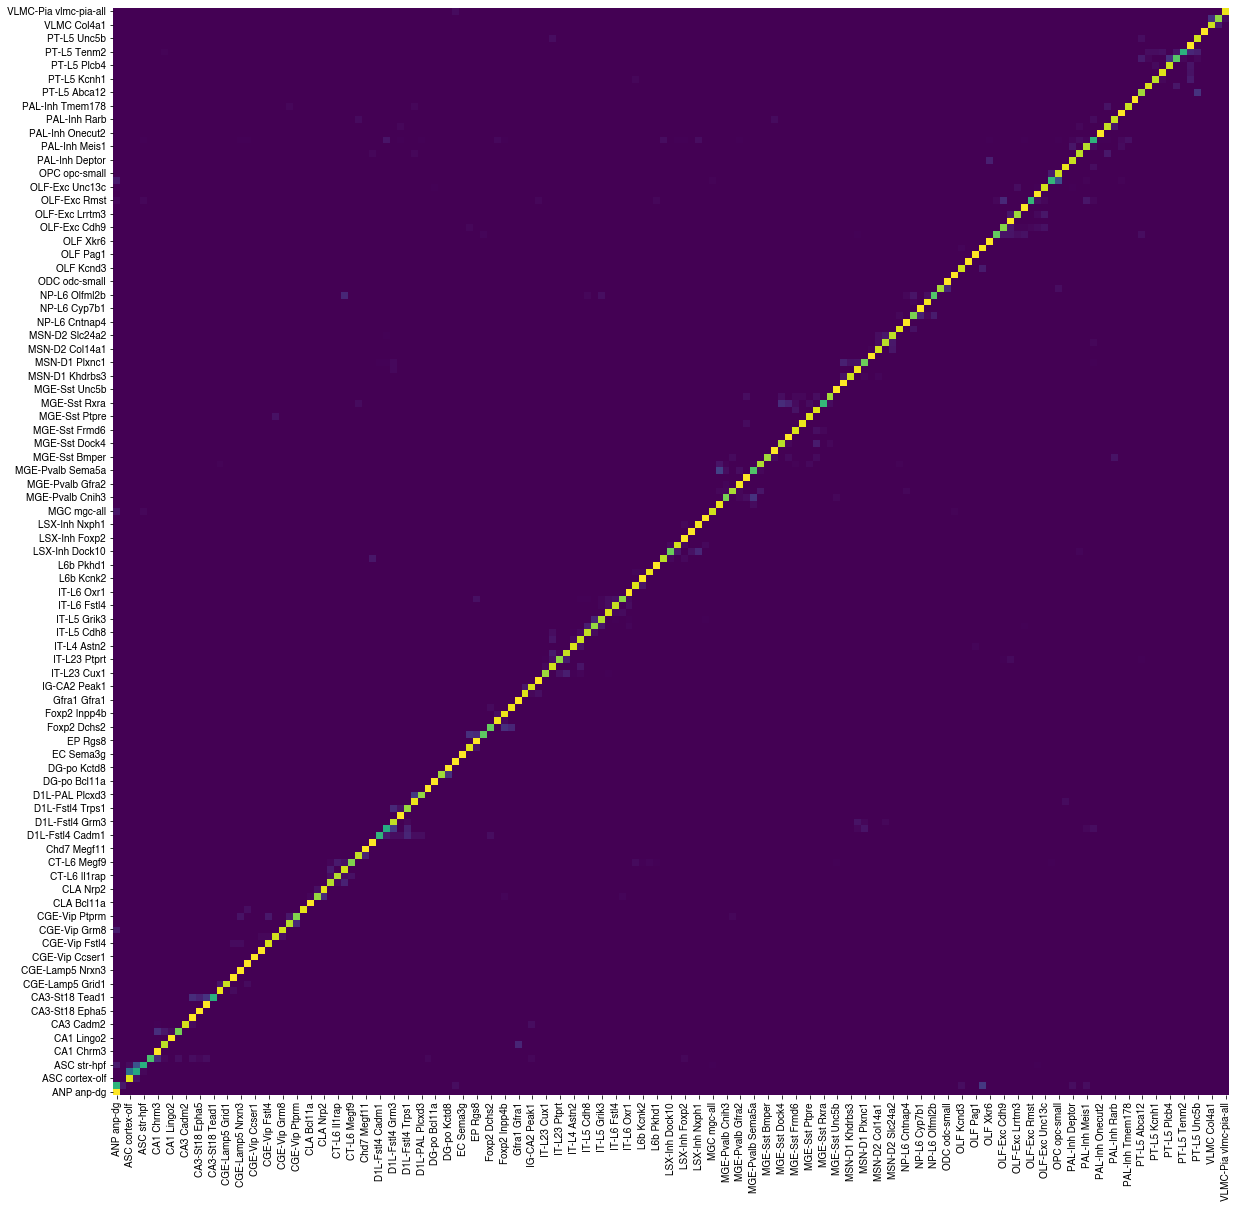

In [35]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(cfm_ratio, cbar=None, vmin=0, vmax=1, cmap='viridis')
ax.set(ylim=(0, cfm_ratio.shape[0]))

In [28]:
cluster_order_map = {c: i for i, c in enumerate(cluster_order)}
test_orders = final_pred_proba.index.map(adata.obs[cluster_col]).map(cluster_order_map)
sort_pred_proba = final_pred_proba.iloc[test_orders.argsort(), :]

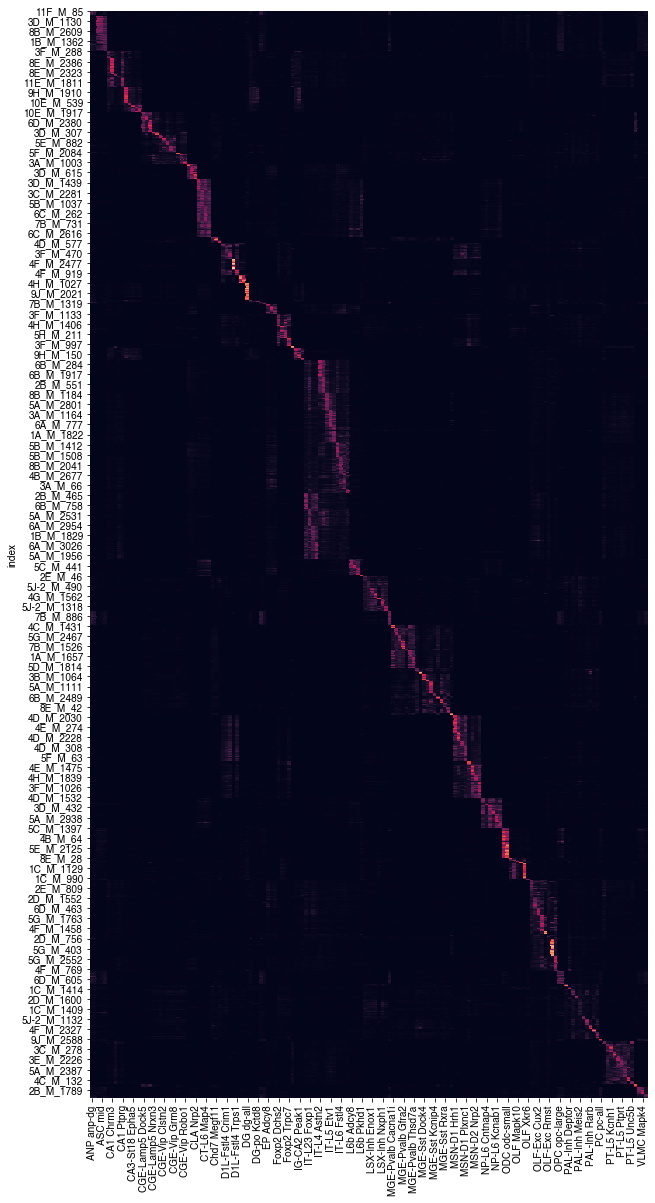

In [29]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(sort_pred_proba, ax=ax, cbar=None)

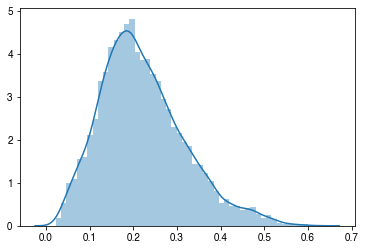

In [30]:
max_proba = []
for cell, cluster in sort_pred_proba.idxmax(axis=1).iteritems():
    max_proba.append(sort_pred_proba.at[cell, cluster])
sns.distplot(max_proba)

In [31]:
with open('finish_flag', 'w') as f:
    f.write('Oh yeah')

## Use model

In [34]:
# example
import joblib

# load data, model and feature
feature_to_use = pd.read_csv('Model/ModelFeature.csv', index_col=0)
adata = anndata.read_h5ad('Adata/cell_by_feature.cov_filter.rate.h5ad')
clf = joblib.load('Model/FinalClassifier.lib')

# make sure all feature exists
feature_var = adata.var.reindex(feature_to_use.index.astype(str))
assert feature_var['chrom'].isna().sum() == 0
adata = adata[:, feature_var.index]

# predict
predicted_label = pd.Series(clf.predict(adata.X), index=adata.obs_names)

# test if possible
true_label = adata.obs[cluster_col]
balanced_accuracy_score(true_label, predicted_label)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:   13.2s
[Parallel(n_jobs=40)]: Done 432 tasks      | elapsed:   22.8s
[Parallel(n_jobs=40)]: Done 720 tasks      | elapsed:   37.7s
[Parallel(n_jobs=40)]: Done 1072 tasks      | elapsed:   54.1s
[Parallel(n_jobs=40)]: Done 1488 tasks      | elapsed:  1.3min
[Parallel(n_jobs=40)]: Done 1968 tasks      | elapsed:  1.7min
[Parallel(n_jobs=40)]: Done 2512 tasks      | elapsed:  2.2min
[Parallel(n_jobs=40)]: Done 3120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=40)]: Done 3792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=40)]: Done 4528 tasks      | elapsed:  3.9min
[Parallel(n_jobs=40)]: Done 5000 out of 5000 | elapsed:  4.3min finished


0.8846467289718347